In [1]:
from importlib import reload
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import pandas as pd
import os
import numpy as np

import feature_extraction as fe
import algorithms_test as algorithms
import evaluate_performance

In [2]:
start_dir = os.getcwd()

In [3]:
training = pd.read_csv("../datasets/audio_training_bal.csv", header=0, index_col=0)
testing = pd.read_csv("../datasets/audio_testing_bal.csv", header=0, index_col=0)
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5400 entries, 41 to 4496
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   GroupName   5400 non-null   object 
 1   Sex         5400 non-null   object 
 2   AgeDays     5400 non-null   int64  
 3   AgeYears    5400 non-null   float64
 4   RecDate     5400 non-null   object 
 5   SourceFile  5400 non-null   object 
 6   Code        5400 non-null   object 
 7   ID          5400 non-null   int64  
 8   CallFile    5400 non-null   object 
 9   CallTime    5400 non-null   object 
 10  CallType    5400 non-null   object 
 11  Path        5400 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 548.4+ KB


In [4]:
training.groupby("Code").size()

Code
VBBF083    300
VBBF088    300
VBBM071    300
VBBM090    300
VRRF180    300
VRRM181    300
VRRM182    300
VRRM183    300
VUKF016    300
VUKF018    300
VUKM004    300
VUKM017    300
VVHM089    300
VWM132     300
VZUF009    300
VZUF014    300
VZUM011    300
VZUM016    300
dtype: int64

In [5]:
# sub-sample 100 calls per individual
tr = training.groupby("Code").sample(n=100, random_state=32)
tr.groupby("Code").size()

Code
VBBF083    100
VBBF088    100
VBBM071    100
VBBM090    100
VRRF180    100
VRRM181    100
VRRM182    100
VRRM183    100
VUKF016    100
VUKF018    100
VUKM004    100
VUKM017    100
VVHM089    100
VWM132     100
VZUF009    100
VZUF014    100
VZUM011    100
VZUM016    100
dtype: int64

In [6]:
testing.groupby("Code").size()

Code
VBBF083    29
VBBF088    29
VBBM071    29
VBBM090    29
VRRF180    29
VRRM181    29
VRRM182    29
VRRM183    29
VUKF016    29
VUKF018    29
VUKM004    29
VUKM017    29
VVHM089    29
VWM132     29
VZUF009    29
VZUF014    29
VZUM011    29
VZUM016    29
dtype: int64

In [7]:
ts = testing.groupby("Code").sample(n=10, random_state=32)
ts.groupby("Code").size()

Code
VBBF083    10
VBBF088    10
VBBM071    10
VBBM090    10
VRRF180    10
VRRM181    10
VRRM182    10
VRRM183    10
VUKF016    10
VUKF018    10
VUKM004    10
VUKM017    10
VVHM089    10
VWM132     10
VZUF009    10
VZUF014    10
VZUM011    10
VZUM016    10
dtype: int64

In [8]:
tr = tr.sample(frac=1, ignore_index=True, random_state=32)
ts = ts.sample(frac=1, ignore_index=True, random_state=32)

## Extract MFCCs

In [9]:
# load audio signals
os.chdir("C:/Users/alessandro/Documents/UZH/Thesis/")
sig, sr = fe.audio(tr["Path"].to_list())

In [10]:
len(sig) == tr.shape[0]

True

In [11]:
sig_ts, sr_ts = fe.audio(ts["Path"].to_list())

In [12]:
# extract MFCCs
coefs, _ = fe.features(
    signals=sig, sample_rates=sr, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs.shape

coefs_ts, _ = fe.features(
    signals=sig_ts, sample_rates=sr_ts, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs_ts.shape

(180, 15, 45)

In [13]:
# targets
y, individuals = fe.get_targets(metadata_df=tr)
y_ts, individuals_ts = fe.get_targets(metadata_df=ts)

## Baseline

In [14]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X_ts = np.reshape(coefs_ts, newshape=(coefs_ts.shape[0], coefs_ts.shape[1]*coefs_ts.shape[2]))
X.shape

(1800, 675)

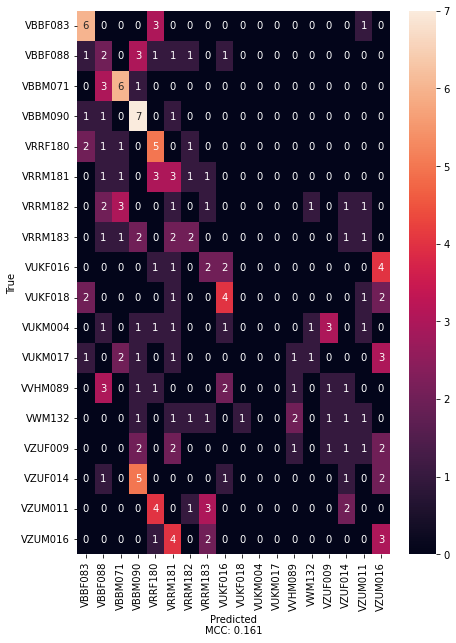

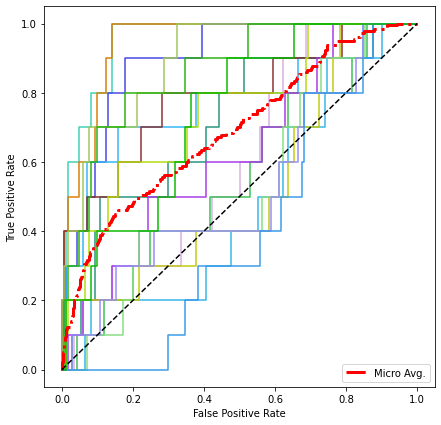

AUC score: 0.697


In [15]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=individuals_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=fe.one_hot(y_ts),
    y_score=prob_b, n_classes=len(individuals_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

## Mean and Std for each coef

In [16]:
X = np.zeros(shape=(coefs.shape[0], coefs.shape[2]*2))
for i in range(coefs.shape[0]):
    mu = np.mean(coefs[i], axis=0)
    sigma = np.std(coefs[i], axis=0)
    X[i] = np.concatenate([mu, sigma])

X_ts = np.zeros(shape=(coefs_ts.shape[0], coefs_ts.shape[2]*2))
for i in range(coefs_ts.shape[0]):
    mu = np.mean(coefs_ts[i], axis=0)
    sigma = np.std(coefs_ts[i], axis=0)
    X_ts[i] = np.concatenate([mu, sigma])
X.shape

(1800, 90)

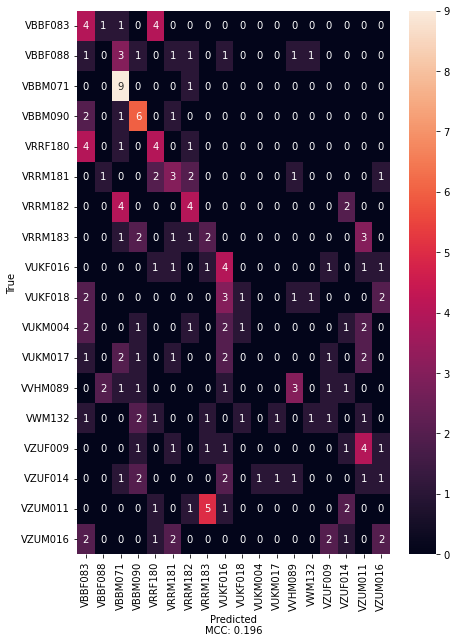

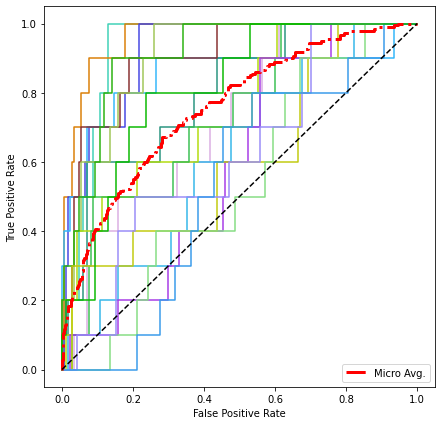

AUC score: 0.759


In [17]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y)
pred_stat, prob_stat = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_stat, labels=individuals_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_stat)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=fe.one_hot(y_ts),
    y_score=prob_stat, n_classes=len(individuals_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

## Reduce number of features

In [18]:
# flattening array
idxs = list(range(15)) + list(range(15, 20)) + list(range(30, 35))
X = np.reshape(coefs[:, :, idxs], newshape=(coefs[:, :, idxs].shape[0], coefs[:, :, idxs].shape[1]*coefs[:, :, idxs].shape[2]))
X_ts = np.reshape(coefs_ts[:, :, idxs], newshape=(coefs_ts[:, :, idxs].shape[0], coefs_ts[:, :, idxs].shape[1]*coefs_ts[:, :, idxs].shape[2]))
X.shape

(1800, 375)

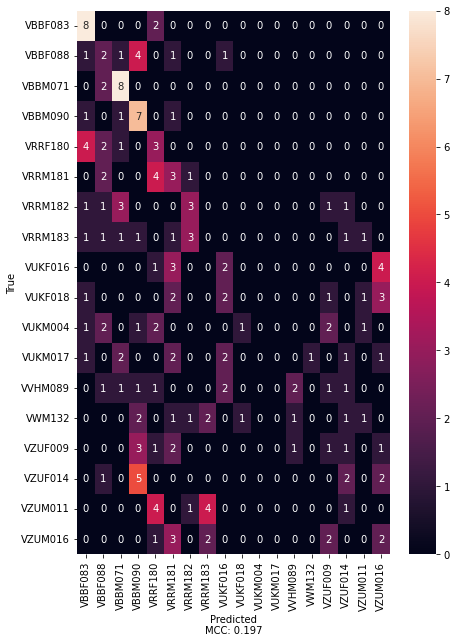

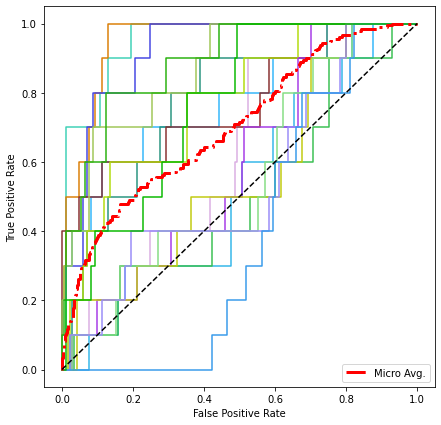

AUC score: 0.704


In [19]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y)
pred_f, prob_f = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_f, labels=individuals_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_f)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=fe.one_hot(y_ts),
    y_score=prob_f, n_classes=len(individuals_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

## Different Extraction

- less n_mfcc (10)

In [20]:
# extract MFCCs
coefs, _ = fe.features(
    signals=sig, sample_rates=sr, n_subsamples=15, n_mels=40,
    n_mfcc=10, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs.shape

coefs_ts, _ = fe.features(
    signals=sig_ts, sample_rates=sr_ts, n_subsamples=15, n_mels=40,
    n_mfcc=10, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs_ts.shape

(180, 15, 27)

In [21]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X_ts = np.reshape(coefs_ts, newshape=(coefs_ts.shape[0], coefs_ts.shape[1]*coefs_ts.shape[2]))
X.shape

(1800, 405)

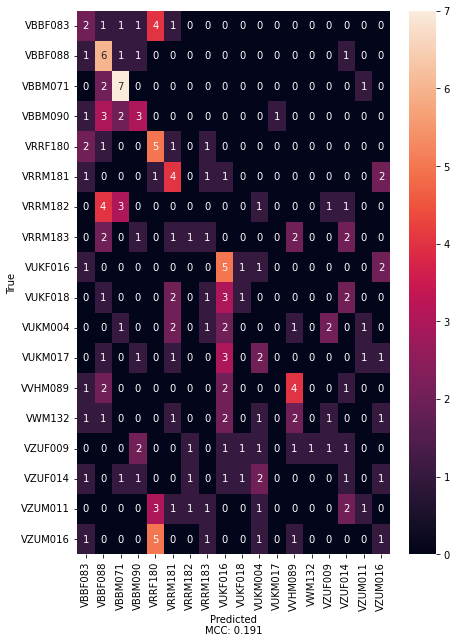

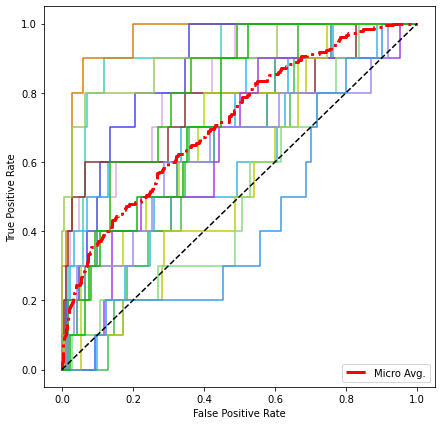

AUC score: 0.717


In [22]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=individuals_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=fe.one_hot(y_ts),
    y_score=prob_b, n_classes=len(individuals_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

- more n_mfcc (25)

In [23]:
# extract MFCCs
coefs, _ = fe.features(
    signals=sig, sample_rates=sr, n_subsamples=15, n_mels=40,
    n_mfcc=25, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs.shape

coefs_ts, _ = fe.features(
    signals=sig_ts, sample_rates=sr_ts, n_subsamples=15, n_mels=40,
    n_mfcc=25, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs_ts.shape

(180, 15, 72)

In [24]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X_ts = np.reshape(coefs_ts, newshape=(coefs_ts.shape[0], coefs_ts.shape[1]*coefs_ts.shape[2]))
X.shape

(1800, 1080)

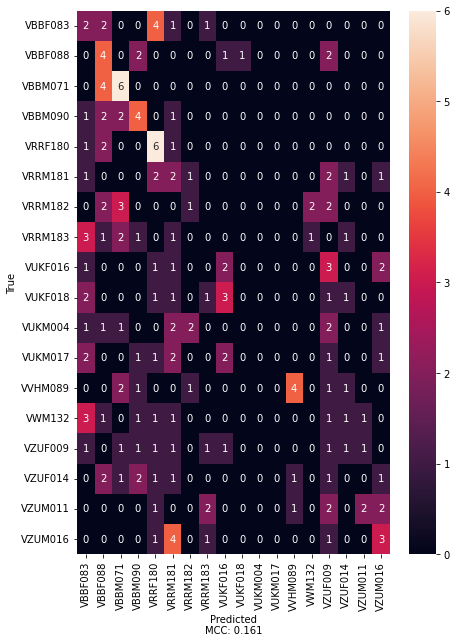

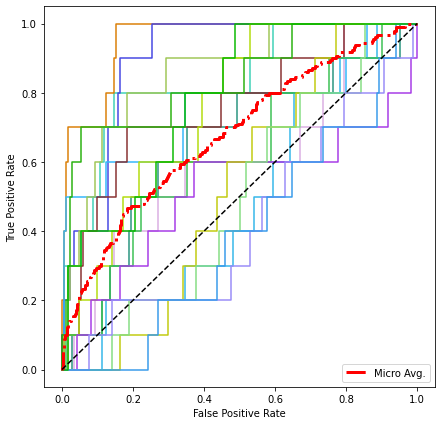

AUC score: 0.672


In [25]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=individuals_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=fe.one_hot(y_ts),
    y_score=prob_b, n_classes=len(individuals_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

- less mels (20)

In [26]:
# extract MFCCs
coefs, _ = fe.features(
    signals=sig, sample_rates=sr, n_subsamples=15, n_mels=20,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs.shape

coefs_ts, _ = fe.features(
    signals=sig_ts, sample_rates=sr_ts, n_subsamples=15, n_mels=20,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs_ts.shape

(180, 15, 45)

In [27]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X_ts = np.reshape(coefs_ts, newshape=(coefs_ts.shape[0], coefs_ts.shape[1]*coefs_ts.shape[2]))
X.shape

(1800, 675)

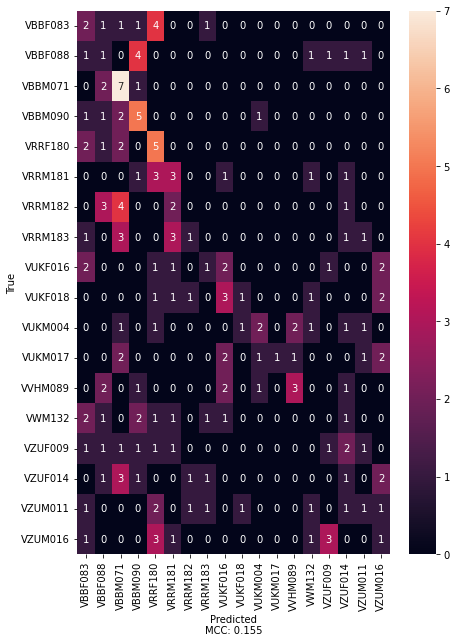

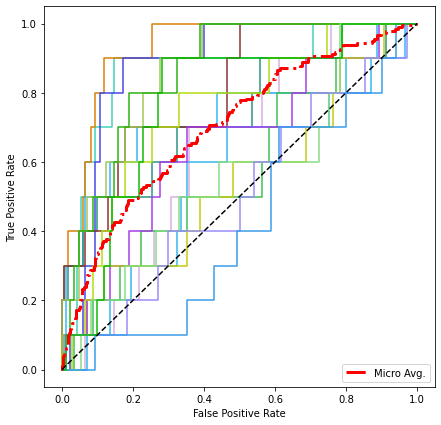

AUC score: 0.702


In [28]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=individuals_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=fe.one_hot(y_ts),
    y_score=prob_b, n_classes=len(individuals_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

- more mels (60)

In [29]:
# extract MFCCs
coefs, _ = fe.features(
    signals=sig, sample_rates=sr, n_subsamples=15, n_mels=60,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs.shape

coefs_ts, _ = fe.features(
    signals=sig_ts, sample_rates=sr_ts, n_subsamples=15, n_mels=60,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs_ts.shape

(180, 15, 45)

In [30]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X_ts = np.reshape(coefs_ts, newshape=(coefs_ts.shape[0], coefs_ts.shape[1]*coefs_ts.shape[2]))
X.shape

(1800, 675)

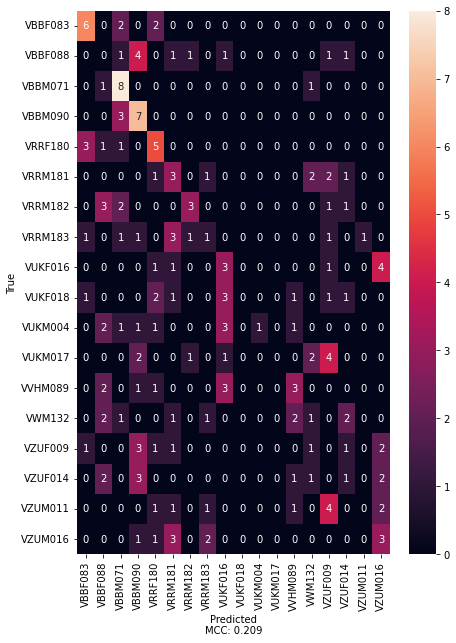

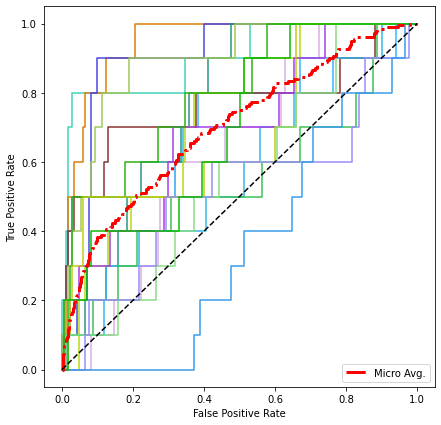

AUC score: 0.704


In [31]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=individuals_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=fe.one_hot(y_ts),
    y_score=prob_b, n_classes=len(individuals_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

- bigger frame stride

In [32]:
# extract MFCCs
coefs, _ = fe.features(
    signals=sig, sample_rates=sr, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.001, fmin=100, fmax=5000
)
coefs.shape

coefs_ts, _ = fe.features(
    signals=sig_ts, sample_rates=sr_ts, n_subsamples=15, n_mels=60,
    n_mfcc=16, frame_stride=0.001, fmin=100, fmax=5000
)
coefs_ts.shape

(180, 15, 45)

In [33]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X_ts = np.reshape(coefs_ts, newshape=(coefs_ts.shape[0], coefs_ts.shape[1]*coefs_ts.shape[2]))
X.shape

(1800, 675)

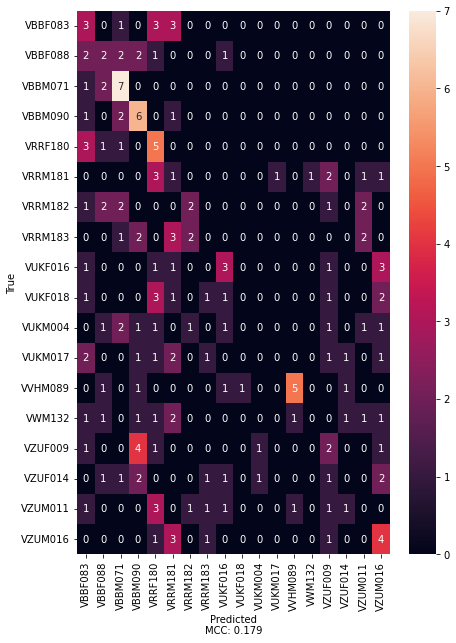

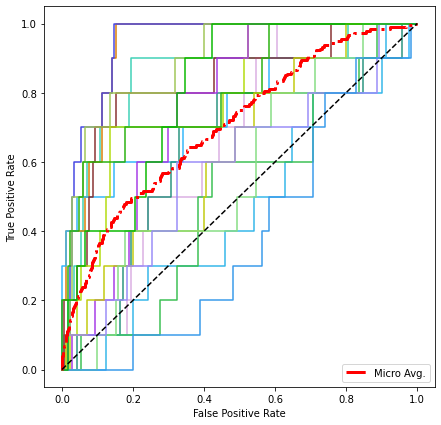

AUC score: 0.709


In [34]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=individuals_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=fe.one_hot(y_ts),
    y_score=prob_b, n_classes=len(individuals_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

- no frequency limit

In [35]:
# extract MFCCs
coefs, _ = fe.features(
    signals=sig, sample_rates=sr, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=0.0, fmax=None
)
coefs.shape

coefs_ts, _ = fe.features(
    signals=sig_ts, sample_rates=sr_ts, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=0.0, fmax=None
)
coefs_ts.shape

(180, 15, 45)

In [36]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X_ts = np.reshape(coefs_ts, newshape=(coefs_ts.shape[0], coefs_ts.shape[1]*coefs_ts.shape[2]))
X.shape

(1800, 675)

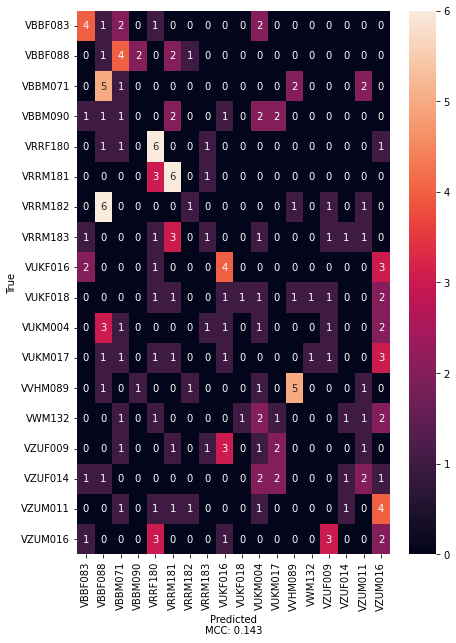

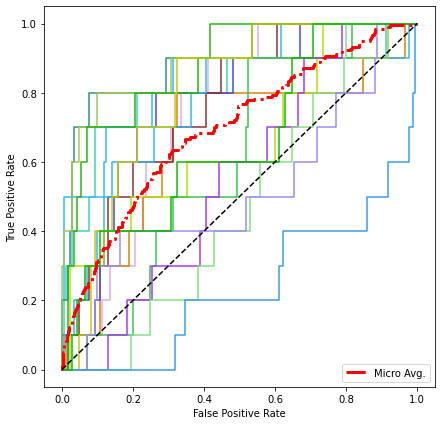

AUC score: 0.693


In [37]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=individuals_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=fe.one_hot(y_ts),
    y_score=prob_b, n_classes=len(individuals_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

- n_fft=2048

In [38]:
# extract MFCCs
coefs, _ = fe.features(
    signals=sig, sample_rates=sr, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000, n_fft=2048
)
coefs.shape

coefs_ts, _ = fe.features(
    signals=sig_ts, sample_rates=sr_ts, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000, n_fft=2048
)
coefs_ts.shape

(180, 15, 45)

In [39]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X_ts = np.reshape(coefs_ts, newshape=(coefs_ts.shape[0], coefs_ts.shape[1]*coefs_ts.shape[2]))
X.shape

(1800, 675)

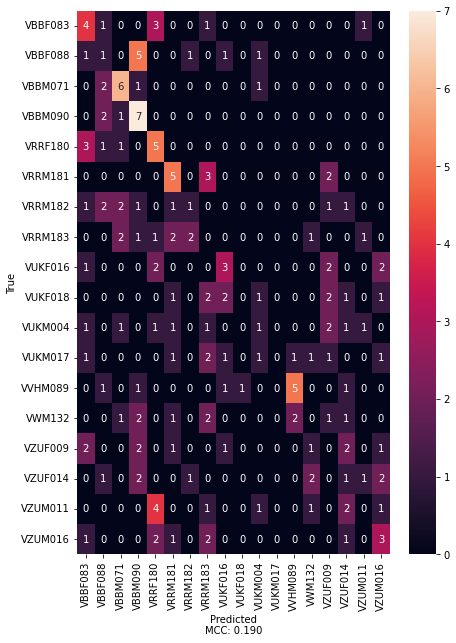

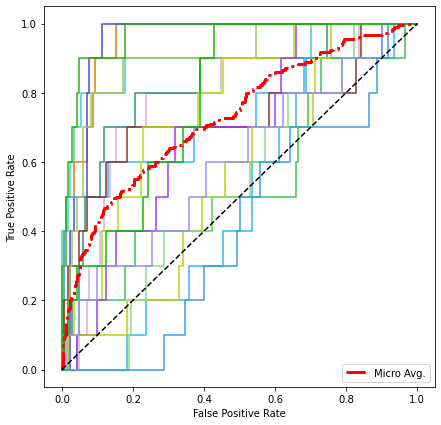

AUC score: 0.726


In [40]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=individuals_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=fe.one_hot(y_ts),
    y_score=prob_b, n_classes=len(individuals_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

- less windows (7)

In [41]:
# extract MFCCs
coefs, _ = fe.features(
    signals=sig, sample_rates=sr, n_subsamples=7, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs.shape

coefs_ts, _ = fe.features(
    signals=sig_ts, sample_rates=sr_ts, n_subsamples=7, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs_ts.shape

(180, 7, 45)

In [42]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X_ts = np.reshape(coefs_ts, newshape=(coefs_ts.shape[0], coefs_ts.shape[1]*coefs_ts.shape[2]))
X.shape

(1800, 315)

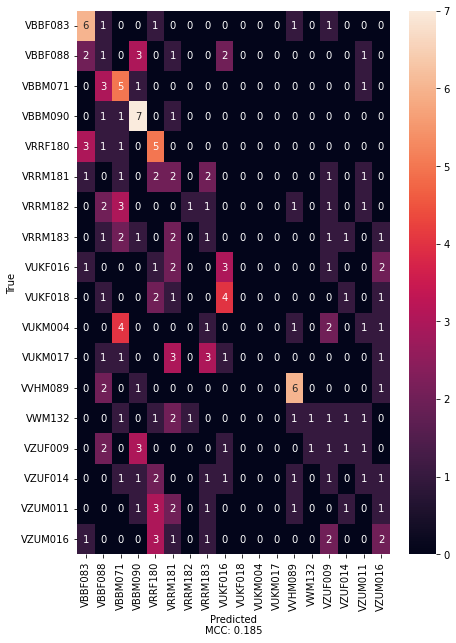

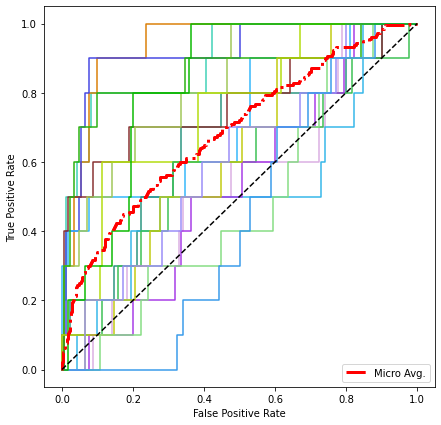

AUC score: 0.691


In [43]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=individuals_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=fe.one_hot(y_ts),
    y_score=prob_b, n_classes=len(individuals_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

- less mfccs (11) and stats

In [44]:
# extract MFCCs
coefs, _ = fe.features(
    signals=sig, sample_rates=sr, n_subsamples=15, n_mels=40,
    n_mfcc=11, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs.shape

coefs_ts, _ = fe.features(
    signals=sig_ts, sample_rates=sr_ts, n_subsamples=15, n_mels=40,
    n_mfcc=11, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs_ts.shape

(180, 15, 30)

In [45]:
X = np.zeros(shape=(coefs.shape[0], coefs.shape[2]*2))
for i in range(coefs.shape[0]):
    mu = np.mean(coefs[i], axis=0)
    sigma = np.std(coefs[i], axis=0)
    X[i] = np.concatenate([mu, sigma])

X_ts = np.zeros(shape=(coefs_ts.shape[0], coefs_ts.shape[2]*2))
for i in range(coefs_ts.shape[0]):
    mu = np.mean(coefs_ts[i], axis=0)
    sigma = np.std(coefs_ts[i], axis=0)
    X_ts[i] = np.concatenate([mu, sigma])
X.shape

(1800, 60)

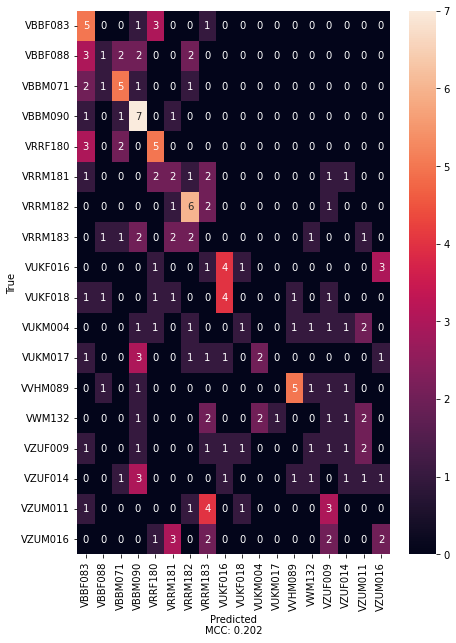

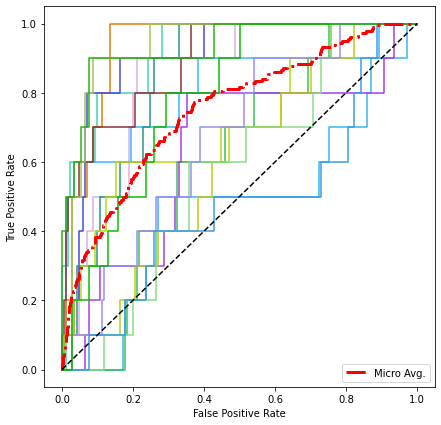

AUC score: 0.752


In [46]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=individuals_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=fe.one_hot(y_ts),
    y_score=prob_b, n_classes=len(individuals_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

- less mfccs (11) and just mean

In [47]:
X = np.zeros(shape=(coefs.shape[0], coefs.shape[2]))
for i in range(coefs.shape[0]):
    mu = np.mean(coefs[i], axis=0)
    X[i] = mu

X_ts = np.zeros(shape=(coefs_ts.shape[0], coefs_ts.shape[2]))
for i in range(coefs_ts.shape[0]):
    mu = np.mean(coefs_ts[i], axis=0)
    X_ts[i] = mu
X.shape

(1800, 30)

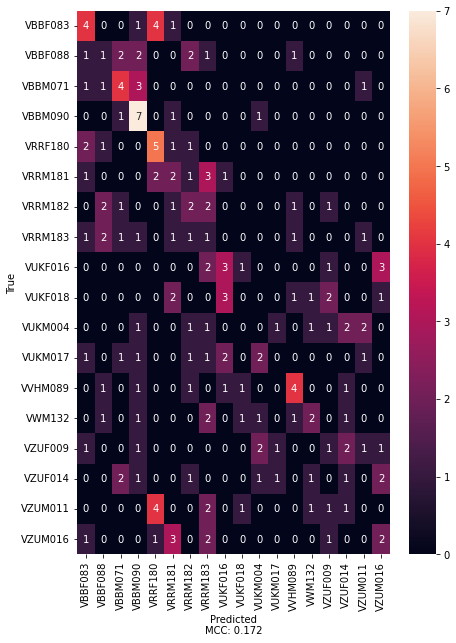

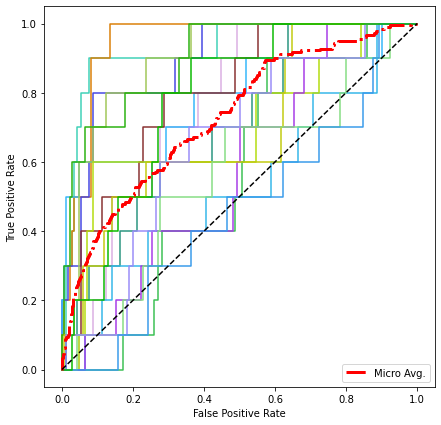

AUC score: 0.727


In [48]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=individuals_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=fe.one_hot(y_ts),
    y_score=prob_b, n_classes=len(individuals_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

- less mfccs (11) and stats + duration

In [49]:
X = np.zeros(shape=(coefs.shape[0], coefs.shape[2]*2 + 1))
for i in range(coefs.shape[0]):
    duration = np.array([len(sig[i]) / sr[i]])
    mu = np.mean(coefs[i], axis=0)
    sigma = np.std(coefs[i], axis=0)
    X[i] = np.concatenate([duration, mu, sigma])

X_ts = np.zeros(shape=(coefs_ts.shape[0], coefs_ts.shape[2]*2 + 1))
for i in range(coefs_ts.shape[0]):
    duration = np.array([len(sig[i]) / sr[i]])
    mu = np.mean(coefs_ts[i], axis=0)
    sigma = np.std(coefs_ts[i], axis=0)
    X_ts[i] = np.concatenate([duration, mu, sigma])
X.shape

(1800, 61)

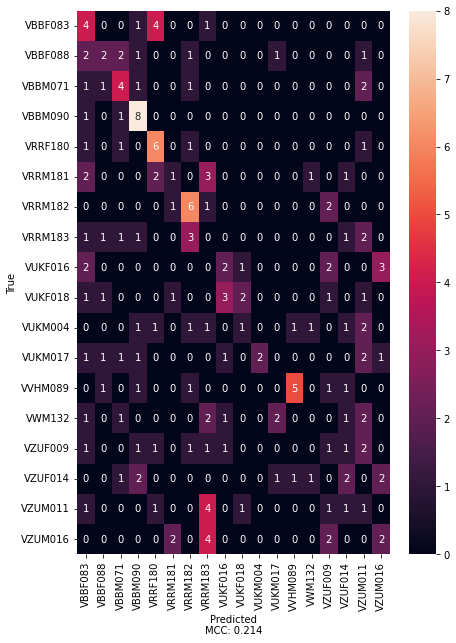

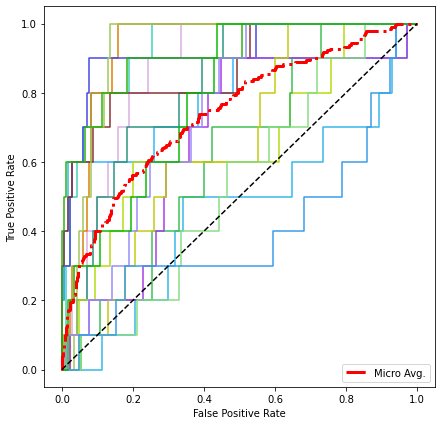

AUC score: 0.747


In [50]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=individuals_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=fe.one_hot(y_ts),
    y_score=prob_b, n_classes=len(individuals_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

- less mfccs (11) and only mfccs and stats + duration

In [51]:
coefs = coefs[:, :, 0:15]
coefs_ts = coefs_ts[:, :, 0:15]

In [52]:
X = np.zeros(shape=(coefs.shape[0], coefs.shape[2]*2 + 1))
for i in range(coefs.shape[0]):
    duration = np.array([len(sig[i]) / sr[i]])
    mu = np.mean(coefs[i], axis=0)
    sigma = np.std(coefs[i], axis=0)
    X[i] = np.concatenate([duration, mu, sigma])

X_ts = np.zeros(shape=(coefs_ts.shape[0], coefs_ts.shape[2]*2 + 1))
for i in range(coefs_ts.shape[0]):
    duration = np.array([len(sig[i]) / sr[i]])
    mu = np.mean(coefs_ts[i], axis=0)
    sigma = np.std(coefs_ts[i], axis=0)
    X_ts[i] = np.concatenate([duration, mu, sigma])
X.shape

(1800, 31)

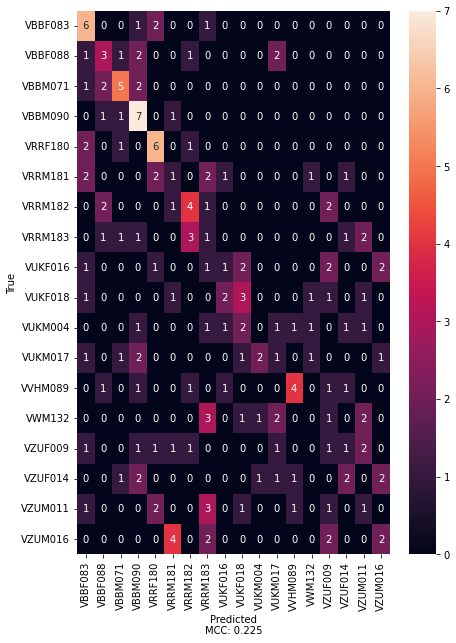

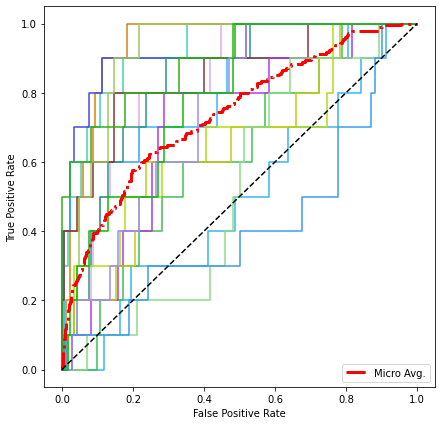

AUC score: 0.748


In [53]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=individuals_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=fe.one_hot(y_ts),
    y_score=prob_b, n_classes=len(individuals_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

## U-Map

In [54]:
import umap

In [55]:
# extract MFCCs
coefs, _ = fe.features(
    signals=sig, sample_rates=sr, n_subsamples=15, n_mels=40,
    n_mfcc=10, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs.shape

coefs_ts, _ = fe.features(
    signals=sig_ts, sample_rates=sr_ts, n_subsamples=15, n_mels=40,
    n_mfcc=10, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs_ts.shape

(180, 15, 27)

In [56]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X_ts = np.reshape(coefs_ts, newshape=(coefs_ts.shape[0], coefs_ts.shape[1]*coefs_ts.shape[2]))
X.shape

(1800, 405)

In [57]:
# X = np.zeros(shape=(coefs.shape[0], coefs.shape[2]*2))
# for i in range(coefs.shape[0]):
#     mu = np.mean(coefs[i], axis=0)
#     sigma = np.std(coefs[i], axis=0)
#     X[i] = np.concatenate([mu, sigma])

# X_ts = np.zeros(shape=(coefs_ts.shape[0], coefs_ts.shape[2]*2))
# for i in range(coefs_ts.shape[0]):
#     mu = np.mean(coefs_ts[i], axis=0)
#     sigma = np.std(coefs_ts[i], axis=0)
#     X_ts[i] = np.concatenate([mu, sigma])
# X.shape

In [58]:
reducer = umap.UMAP(
    n_neighbors=100,
    min_dist=0.1,
    n_components=3,
    metric="manhattan",
    random_state=42,
    target_weight=0.3
    )

reducer.fit(X, y=y)
tr_X = reducer.transform(X)
print(tr_X.shape)


(1800, 3)


C:\Users\ALESSA~2\AppData\Local\Temp/ipykernel_11772/2244185329.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


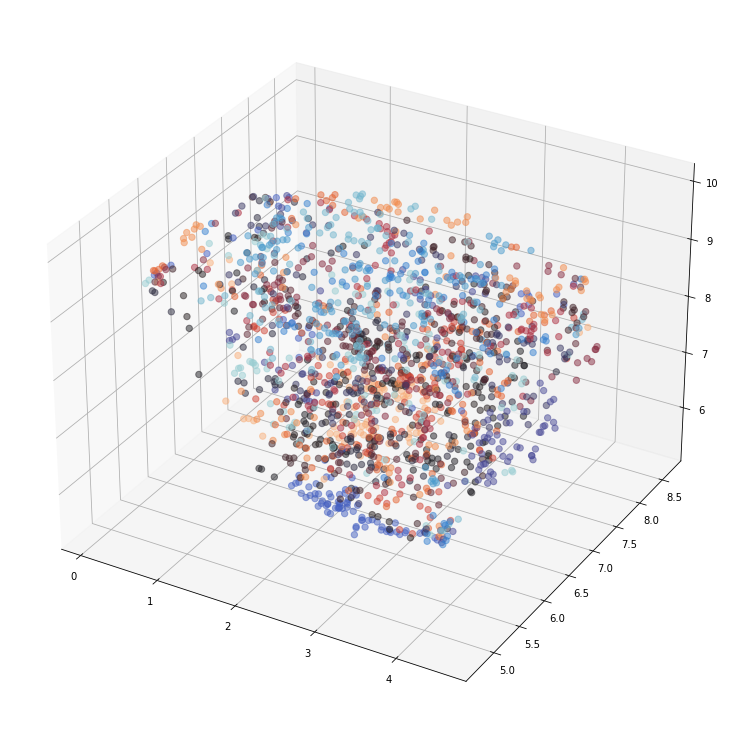

In [59]:
fig = plt.figure(figsize=(10,10))

if tr_X.shape[1] > 2:

    ax = Axes3D(fig)
    ax.scatter(
        tr_X[:, 0],
        tr_X[:, 1],
        tr_X[:, 2],
        c=[
            sns.color_palette(palette="icefire", n_colors=len(set(y)))[x] \
                for x in y
            ],
        s=40,
        alpha=0.5
        )

else:
    
    plt.scatter(
        tr_X[:, 0],
        tr_X[:, 1],
        c=[
            sns.color_palette(palette="icefire", n_colors=len(set(y)))[x] \
                for x in y
            ],
        s=40,
        alpha=0.5
    )

C:\Users\ALESSA~2\AppData\Local\Temp/ipykernel_11772/765505724.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


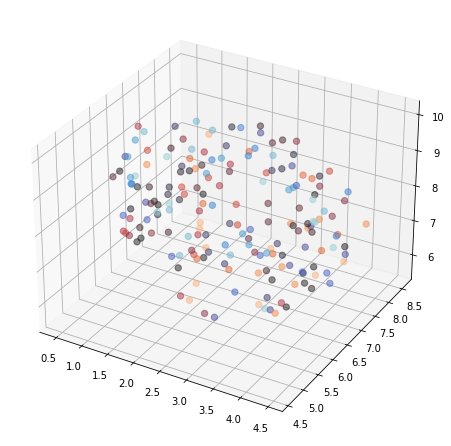

In [60]:
tr_X_ts = reducer.transform(X=X_ts)

fig = plt.figure(figsize=(6,6))

if tr_X_ts.shape[1] > 2:

    ax = Axes3D(fig)
    ax.scatter(
        tr_X_ts[:, 0],
        tr_X_ts[:, 1],
        tr_X_ts[:, 2],
        c=[
            sns.color_palette(palette="icefire", n_colors=len(set(y_ts)))[x] \
                for x in y_ts
            ],
        s=40,
        alpha=0.5
        )

else:
    
    plt.scatter(
        tr_X_ts[:, 0],
        tr_X_ts[:, 1],
        c=[
            sns.color_palette(palette="icefire", n_colors=len(set(y_ts)))[x] \
                for x in y_ts
            ],
        s=40,
        alpha=0.5
    )

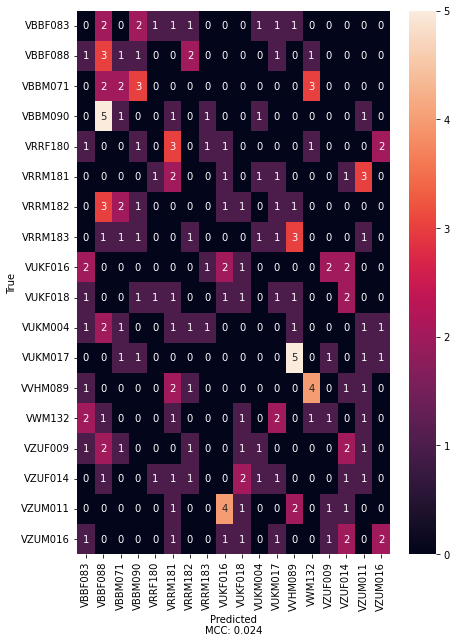

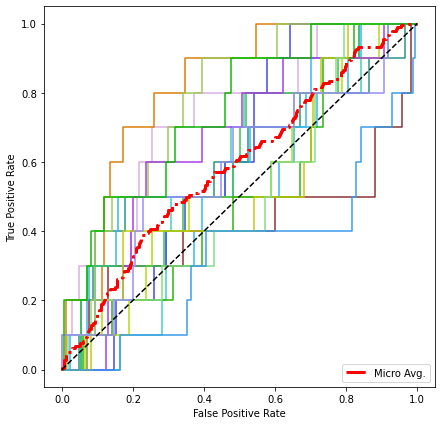

AUC score: 0.590


In [61]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=tr_X, y=y)
pred_b, prob_b = rf.predict(X=tr_X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=individuals_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=fe.one_hot(y_ts),
    y_score=prob_b, n_classes=len(individuals_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

In [62]:
reducer = umap.UMAP(
    n_neighbors=100,
    min_dist=0.1,
    n_components=50,
    metric="manhattan",
    random_state=42,
    target_weight=0.3
    )

reducer.fit(X, y=y)
tr_X = reducer.transform(X)
print(tr_X.shape)
tr_X_ts = reducer.transform(X=X_ts)

(1800, 50)


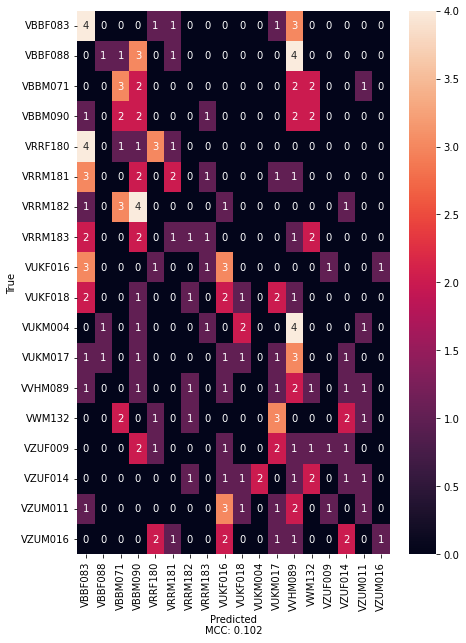

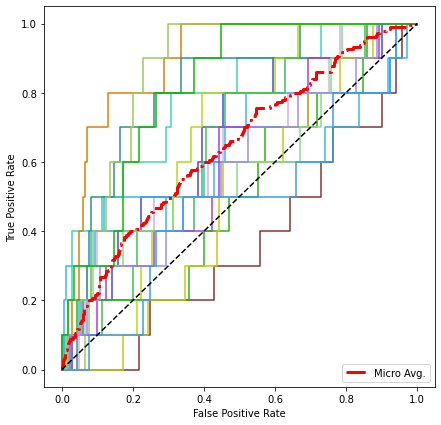

AUC score: 0.644


In [63]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=tr_X, y=y)
pred_b, prob_b = rf.predict(X=tr_X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=individuals_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=fe.one_hot(y_ts),
    y_score=prob_b, n_classes=len(individuals_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))